In [46]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging
from importlib import reload
from src import embeddings_filter
from tqdm import tqdm
import collections
import json
import bz2

In [52]:
# df = pd.io.json.read_json('data/data', lines=True,encoding='utf-8', encoding_errors='ignore')
# df.sample(10)
list_of_dict = []
k = 0
with bz2.open('data/cosine.json.bz2', 'rb') as s_file:
    while k < 328740:
        d =  json.loads(next(s_file))
        list_of_dict.append(d)
        k+=1

df = pd.DataFrame(list_of_dict)

In [69]:
df.describe()

0.2808758616447449

In [70]:
df.sort_values(by='cosine_similarity',ascending=True).head(10)

,quoteID,quotation,speaker,qids,date,numOccurrences,urls,tokenized,cosine_similarity
57637,2015-02-19-049382,"It would be hard to see him leave, but I would...",John Schneider,"[Q16832535, Q16984394, Q1701691, Q20404155, Q2...",2015-02-19 22:50:00,1,[http://www.seahawks.com/news/articles/article...,it would hard see leav i would think market wo...,0.0
222762,2015-09-15-090072,The fact that overconfident populations are ev...,"Jon Huntsman , Jr. .",[Q11607],2015-09-15 19:00:00,2,[http://blogs.alternet.org/environment/climate...,the fact overconfid popul evolutionarili stabl...,0.0
212275,2015-09-13-046397,The market understands that UQ is theoretical ...,Bob O'Connor,[Q4933538],2015-09-13 09:38:49,1,[http://www.afr.com/leadership/management/busi...,the market understand uq theoret social griffi...,0.0
40799,2015-12-03-032639,highlight corruption schemes principally invol...,Attorney General Loretta Lynch,[Q6680965],2015-12-03 14:59:45,1,[http://wusa9.com/story/sports/soccer/2015/12/...,highlight corrupt scheme princip involv soccer...,0.0
135172,2015-09-07-013841,Gen Z's constant demand for workstyle innovati...,David Mills,"[Q1175691, Q19918299, Q21452753, Q25189625, Q3...",2015-09-07 13:30:11,1,[http://www.microscope.co.uk/news/4500253018/G...,gen zs constant demand workstyl innov everpres...,0.0
14101,2015-05-13-004079,Are we worried about China? If it's relative t...,Carlos Ghosn,[Q356719],2015-05-13 07:09:29,1,[http://uk.reuters.com/article/2015/05/13/uk-n...,are worri china if rel market evolut\n,0.0
134944,2015-02-27-016240,Falling positive customer experience ratings c...,Jean Lassignardie,[Q33221137],2015-02-27 12:15:00,1,[http://www.bobsguide.com/guide/news/2015/Feb/...,fall posit custom experi rate coupl grow numbe...,0.0
282633,2015-07-17-015048,"Consumption habits have shifted, and a signifi...",Michael Loubser,[Q20981687],2015-07-17 17:31:02,2,[http://www.smartbrief.com/servlet/rdrc?u=/new...,consumpt habit shift signific portion market g...,0.0
196573,2015-03-31-075032,The share of digital origination of credit is ...,Kunal Bahl,[Q19665061],2015-03-31 10:41:00,1,[http://www.dnaindia.com/money/report-snapdeal...,the share digit origin credit pois grow today ...,0.0
134937,2015-06-26-068822,With the drought in California and Arizona and...,Rick Doyle,[Q1249097],2015-06-26 23:03:16,1,[http://www.reviewjournal.com/business/economi...,with drought california arizona southern nevad...,0.0


In [76]:
df[df.quantile(q=0.05)['cosine_similarity'] >df['cosine_similarity']].to_pickle('sample_data.pkl.zip')

## Preprocessing
We have the following stats for the preprocessing:
Finished initial Preprocessing
Total processed Quotes:  20874338
Of which no speaker:  7016300
Of which uncertain:  6560
Of which not tokenizable:  0
Total Quotes written:  13851478

## Filtering
We load our pretrained fasttext model. We test the model by finding the closet terms to market.

In [2]:
# convenience for faster testing in notebook
reload(embeddings_filter)

model = embeddings_filter.load_embeddings(get_model=True)
model.get_nearest_neighbors('market')

[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[(0.950352668762207, 'marketq'),
 (0.9497827887535095, 'marketg'),
 (0.948558509349823, 'market6'),
 (0.9429478049278259, 'marketbymarket'),
 (0.9422717094421387, 'marketyet'),
 (0.9384009838104248, 'marketpric'),
 (0.9382206797599792, 'marketit'),
 (0.9377272725105286, 'onmarket'),
 (0.9374149441719055, 'marketgo'),
 (0.9372236728668213, 'marketsit')]

As we can see, they are almost synonyms as expected.

We define our keywords and setup functions to measure the similarity:

In [24]:
# setup
keywords = ['market','stocks', 'trade', 'bonds']
similarity = embeddings_filter.get_similarity_measure(keywords, model)
generator = embeddings_filter.data_gen()

PROBABILITY_THRESHOLD = 0.5

i = 0
speakers = collections.defaultdict(list)
for data in generator:
    # Ignore if speaker is uncertain or none
    if data['speaker'] == 'None' or float(data['probas'][0][1]) < PROBABILITY_THRESHOLD:
        continue
    score = similarity(data['quotation'])
    if score == 0:
        continue
    speakers[data['speaker']].append(similarity(data['quotation']))

    i += 1
    if i > 100000:
        break

Simiarity failed for:  to have all that.
Simiarity failed for:  is not what we're about.


In [25]:
for k in speakers:
    speakers[k] = sum(speakers[k])/len(speakers[k])

array([[<AxesSubplot:title={'center':'similarity'}>]], dtype=object)

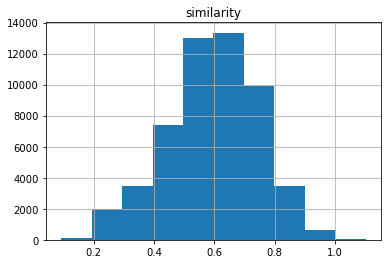

In [26]:
speakers_df = pd.DataFrame.from_dict(speakers, orient='index', columns=['similarity']).sort_values('similarity', ascending=False)
speakers_df.hist()